# MDC 018 - Projeto Final

In [116]:
import pandas as pd

# Carregando os dados de treinamento e teste
train_critic = pd.read_csv("train_critic.csv")

test_critic = pd.read_csv("test_critic.csv")

In [117]:
train_critic

,Show,Sentiment,Review
0,Bodyguard,1,"This has been a brilliant, compulsive, five-star mind trip of a series."
1,Mad Men,0,"With each new season, I try to remind myself that the show is a slow burn. The first episode wasn't as glacial as the first episode of last season, but it still dragged a bit."
2,1971: The Year That Music Changed Everything,1,"Here's one of the most all-encompassing and stunning music documentary experiences that I've ever seen. Allow the information to take hold and process, and you'll feel your own creativity and interests blossom."
3,Six Feet Under,1,"To me, it was one of the most clever, funny, subversive, wicked, playful and tender shows ever to emerge from the US. It tackled the big themes: family, the importance of friendship, bonds between human beings."
4,Pieces of Her,0,"Well acted and highly suspenseful, the eight-part Netflix thriller “Pieces of Her” never lets up. This is a good thing for the first five episodes. Then it grows exhausting."
...,...,...,...
11827,Freaks and Geeks,1,"Freaks and Geeks boasts an extremely talented cast, evident by the fact that most of the members have gone on to notable careers in television and film."
11828,The Gilded Age,1,"It's a period piece set in 1882 New York that can be watched as a history lesson but still keeps things entertaining with melodrama and romance. There's an infinite array of chic gowns, mentions of tea and apple tarts, and women have the juiciest roles."
11829,Joe vs Carole,1,McKinnon and her co-producers must be credited for conveying the tale in as serious-minded a fashion as possible. In so doing they have achieved something the original Netflix documentary had little interest in attempting.
11830,Rick and Morty,1,"As season openers go, this is a really solid entry from Rick and Morty. Nimbus is an instantly memorable character and the Morty storyline is a reminder that Morty is capable of having hilarious adventures without Rick's direct involvement."


Verificação de balanceamento:

In [118]:
train_critic['Sentiment'].value_counts()


Sentiment
1    9995
0    1837
Name: count, dtype: int64

Ambos conjuntos estão fortemente desbalanceados.

# Predição de sentimento

Conjunto train_critic

In [119]:
# Separação entre conjunto de treino e validação
from sklearn.model_selection import train_test_split

# Remove NAs
train_critic.dropna(subset=['Review'], inplace=True)

(train_critic_df, val_critic_df) = train_test_split(train_critic, test_size=0.2)
train_critic_df['Sentiment'].value_counts()

Sentiment
1    7992
0    1472
Name: count, dtype: int64

In [120]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Calcular os pesos para as classes
classes = train_critic['Sentiment'].unique()
weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array(classes),
    y=train_critic['Sentiment']
)

class_weights = dict(zip(classes, weights))
class_weights

{np.int64(1): np.float64(0.5918459229614808),
 np.int64(0): np.float64(3.221949891067538)}

In [121]:
val_critic_texts = val_critic_df["Review"].tolist()
val_critic_labels = val_critic_df["Sentiment"].tolist()

In [122]:
from sklearn.metrics import balanced_accuracy_score
from transformers import pipeline
import matplotlib.pyplot as plt

def get_balanced_accuracy(model, tokenizer, texts, labels):
    classifier = pipeline("text-classification", model=model, tokenizer=tokenizer)
    predictions = []

    for text in texts:
        result = classifier(text)
        label = int(result[0]["label"].split("_")[-1])
        predictions.append(label)
    return round(float(balanced_accuracy_score(labels, predictions)),2)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


def plot_confusion_matrix(trainer, dataset, label_names=None, cmap="Blues"):
    predictions_output = trainer.predict(dataset)
    logits = predictions_output.predictions
    labels = predictions_output.label_ids
    predictions = logits.argmax(axis=-1)
    cm = confusion_matrix(labels, predictions,  normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
    disp.plot(cmap=cmap, values_format=".2f")
    plt.show()
    return cm

In [123]:
from transformers import BertForSequenceClassification, BertTokenizer, Trainer, TrainingArguments
from sklearn.utils.class_weight import compute_class_weight
import torch
import numpy as np
from datasets import Dataset
from transformers import Trainer, TrainingArguments
from sklearn.metrics import balanced_accuracy_score


model_name = "prajjwal1/bert-tiny"  # Ou outro checkpoint pré-treinado
num_labels = 2  # Número de classes no seu problema

model = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
tokenizer = BertTokenizer.from_pretrained(model_name)
# Supondo que 'labels' contenha todos os rótulos do conjunto de treinamento
labels = train_critic['Sentiment']  # Altere para acessar os rótulos no seu dataset

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [124]:
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float)  # Converta para um tensor PyTorch
import torch.nn as nn

#tokeniza os datasets
train_encodings = tokenizer(train_critic_df['Review'].tolist(), truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(list(val_critic_df['Review']), truncation=True, padding=True, max_length=128)

In [125]:
class CustomTrainer(Trainer):
    def __init__(self, class_weights, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        # Define a função de perda com os pesos de classe
        loss_fct = nn.CrossEntropyLoss(weight=self.class_weights.to(logits.device))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [126]:
import evaluate
from sklearn.metrics import balanced_accuracy_score

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = metric.compute(predictions=predictions, references=labels)
    return accuracy

def compute_metrics_balanced(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    # Calcular acurácia balanceada
    balanced_acc = balanced_accuracy_score(labels, predictions)

    return {"balanced_accuracy": balanced_acc}

In [127]:
training_args = TrainingArguments(
    output_dir="./results_critic_baseline",
    learning_rate=5e-5,
    num_train_epochs=8,
    weight_decay=0.01,
    logging_dir="./logs",
    eval_strategy="epoch",
    load_best_model_at_end=True,               # Carregar o melhor modelo ao final
    metric_for_best_model="balanced_accuracy", # Métrica para determinar o melhor modelo
    save_strategy="epoch",                     # Salvar checkpoints no final de cada época
    save_total_limit=1,                        # Limitar os checkpoints a 1 para economizar espaço
    greater_is_better=True                     # Se maior métrica significa melhor modelo
)
train_critic_dataset = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'labels': list(train_critic_df['Sentiment'])
})

val_critic_dataset = Dataset.from_dict({
    'input_ids': val_encodings['input_ids'],
    'attention_mask': val_encodings['attention_mask'],
    'labels': list(val_critic_df['Sentiment'])
})

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_critic_dataset,
    eval_dataset=val_critic_dataset,
    class_weights=class_weights,
    compute_metrics=compute_metrics_balanced
)
trainer.train()

C:\Users\p.moura\.virtualenvs\mdc-projeto-final\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Balanced Accuracy
1,0.636500,0.603620,0.687662
2,0.526700,0.553767,0.724069
3,0.508600,0.671923,0.703075
4,0.448600,1.011521,0.645493
5,0.442600,0.976120,0.695702
6,0.428700,1.133222,0.681837
7,0.344800,1.165139,0.687581
8,0.314200,1.163717,0.694826


TrainOutput(global_step=9464, training_loss=0.45886574371931216, metrics={'train_runtime': 634.9845, 'train_samples_per_second': 119.234, 'train_steps_per_second': 14.904, 'total_flos': 13902622056960.0, 'train_loss': 0.45886574371931216, 'epoch': 8.0})

In [128]:
get_balanced_accuracy(model, tokenizer, val_critic_texts, val_critic_labels)

0.72

In [129]:
trainer.evaluate()

{'eval_loss': 0.5537670254707336,
 'eval_balanced_accuracy': 0.7240691161060606,
 'eval_runtime': 2.0567,
 'eval_samples_per_second': 1150.857,
 'eval_steps_per_second': 143.918,
 'epoch': 8.0}

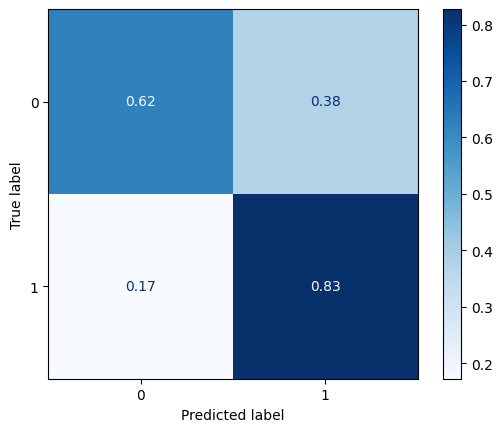

array([[0.62087912, 0.37912088],
       [0.17274089, 0.82725911]])

In [130]:
plot_confusion_matrix(trainer,val_critic_dataset)

# Teste

In [131]:
test_critic_texts = test_critic["Review"].tolist()
test_critic_labels = test_critic["Sentiment"].tolist()
get_balanced_accuracy(model, tokenizer, test_critic_texts, test_critic_labels)

0.69

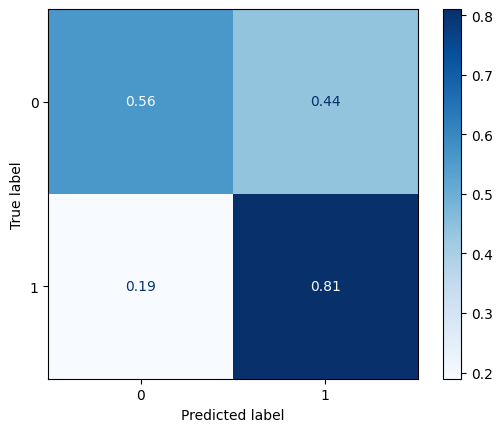

array([[0.56124722, 0.43875278],
       [0.18964143, 0.81035857]])

In [132]:
test_encodings = tokenizer(list(test_critic['Review']), truncation=True, padding=True, max_length=128)
test_critic_dataset = Dataset.from_dict({
    'input_ids': test_encodings['input_ids'],
    'attention_mask': test_encodings['attention_mask'],
    'labels': list(test_critic['Sentiment'])
})
plot_confusion_matrix(trainer,test_critic_dataset)